In [1]:
# ============================================================
# SKRIPSI - KLASIFIKASI CITRA ENDOSKOPI DENGAN CONVNEXT-TINY
# TRAINING LOCAL COLAB (DATASET KAGGLE)
# ============================================================

# ============================================================
# Step 1: Upload API Key Kaggle (kaggle.json)
# ============================================================
from google.colab import files
print("Upload file 'kaggle.json'")
uploaded = files.upload()

import os, json
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod("/root/.kaggle/kaggle.json", 600)
print("✅ Kaggle API key berhasil disimpan.")

# ============================================================
# Step 2: Download Dataset dari Kaggle
# ============================================================
!pip install -q kaggle
!kaggle datasets download -d huangthecreator/gastroendonet -p /content/
!unzip -q /content/gastroendonet.zip -d /content/
!mv /content/gastroendonet/dataset /content/dataset
!rm -rf /content/gastroendonet*
print("Dataset berhasil diunduh dan disiapkan di /content/dataset")

# Struktur:
# /content/dataset/original/...
# /content/dataset/augmented/...

# ============================================================
# 🔹 Step 3: Mount Google Drive untuk backup hasil
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 🔹 Step 4: Konfigurasi Skenario
# ============================================================
import torch, random, numpy as np, os

AUGMENT_ACTIVE   = True        # True -> gabung original + augmented | False -> hanya original
NORMALIZE_ACTIVE = False        # True -> gunakan mean-std ImageNet
BATCH_SIZE       = 16          # 16 / 32 / 64
SEED             = 42          # seed global

# Path lokal
ROOT_DIR = "/content"
DATA_ROOT = os.path.join(ROOT_DIR, "dataset")

# Path hasil di local Colab
scenario_id = f"{'1a' if AUGMENT_ACTIVE else '1b'}-" \
              f"{'2a' if NORMALIZE_ACTIVE else '2b'}-" \
              f"{'3a' if BATCH_SIZE == 16 else '3b' if BATCH_SIZE == 32 else '3c'}"

RESULT_LOCAL = os.path.join(ROOT_DIR, "results", scenario_id)
os.makedirs(RESULT_LOCAL, exist_ok=True)

# Path hasil di Google Drive (untuk backup akhir)
RESULT_DRIVE = f"/content/drive/MyDrive/gerdpolyp-thesisv2/results/{scenario_id}"
os.makedirs(os.path.dirname(RESULT_DRIVE), exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"🧪 Scenario: {scenario_id}")
print(f"📂 Dataset: {DATA_ROOT}")
print(f"📁 Output local: {RESULT_LOCAL}")
print(f"⚙️ Device: {DEVICE}")


Upload file 'kaggle.json'


Saving kaggle.json to kaggle.json
✅ Kaggle API key berhasil disimpan.
Dataset URL: https://www.kaggle.com/datasets/huangthecreator/gastroendonet
License(s): unknown
 99% 2.21G/2.24G [00:31<00:00, 41.6MB/s]
100% 2.24G/2.24G [00:31<00:00, 76.5MB/s]
mv: cannot stat '/content/gastroendonet/dataset': No such file or directory
Dataset berhasil diunduh dan disiapkan di /content/dataset
Mounted at /content/drive
🧪 Scenario: 1a-2b-3a
📂 Dataset: /content/dataset
📁 Output local: /content/results/1a-2b-3a
⚙️ Device: cuda


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json


In [3]:
# --- PILIH DATASET ---
if AUGMENT_ACTIVE:
    data_dirs = [
        os.path.join(DATA_ROOT, "original"),
        os.path.join(DATA_ROOT, "augmented")
    ]
else:
    data_dirs = [os.path.join(DATA_ROOT, "original")]

# --- TRANSFORMASI ---
if NORMALIZE_ACTIVE:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
else:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

# --- LOAD DATASET ---
from torch.backends import cudnn
cudnn.benchmark = True  # optimalkan GPU kernel
datasets_list = [datasets.ImageFolder(d, transform=transform) for d in data_dirs]
dataset = ConcatDataset(datasets_list)

num_total = len(dataset)
train_size = int(0.7 * num_total)
val_size   = int(0.2 * num_total)
test_size  = num_total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 19629 | Val: 5608 | Test: 2805


In [4]:
model = models.convnext_tiny(weights="IMAGENET1K_V1")

# Ganti classifier sesuai jumlah kelas (4)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 4)
model = model.to(DEVICE)

# Full fine-tuning
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 134MB/s]


In [5]:
EPOCHS = 20
PATIENCE = 10

best_val_loss = float("inf")
no_improve = 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total

    # --- VALIDASI ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    history["train_loss"].append(train_loss / len(train_loader))
    history["val_loss"].append(val_loss / len(val_loader))
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"TrainLoss: {train_loss/len(train_loader):.4f} | "
          f"ValLoss: {val_loss/len(val_loader):.4f} | "
          f"ValAcc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), os.path.join(RESULT_LOCAL, "model_best.pth"))
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

pd.DataFrame(history).to_csv(os.path.join(RESULT_LOCAL, "history.csv"), index=False)


Epoch [1/20] | TrainLoss: 1.3832 | ValLoss: 1.3804 | ValAcc: 0.2921
Epoch [2/20] | TrainLoss: 1.3773 | ValLoss: 1.3759 | ValAcc: 0.2921
Epoch [3/20] | TrainLoss: 1.3789 | ValLoss: 1.3756 | ValAcc: 0.2921
Epoch [4/20] | TrainLoss: 1.3765 | ValLoss: 1.3763 | ValAcc: 0.2921
Epoch [5/20] | TrainLoss: 1.3766 | ValLoss: 1.3770 | ValAcc: 0.2921
Epoch [6/20] | TrainLoss: 1.3765 | ValLoss: 1.3768 | ValAcc: 0.2921
Epoch [7/20] | TrainLoss: 1.3764 | ValLoss: 1.3756 | ValAcc: 0.2921
Epoch [8/20] | TrainLoss: 1.3764 | ValLoss: 1.3754 | ValAcc: 0.2921
Epoch [9/20] | TrainLoss: 1.3765 | ValLoss: 1.3780 | ValAcc: 0.2673
Epoch [10/20] | TrainLoss: 1.3761 | ValLoss: 1.3779 | ValAcc: 0.2921
Epoch [11/20] | TrainLoss: 1.3758 | ValLoss: 1.3778 | ValAcc: 0.2673
Epoch [12/20] | TrainLoss: 1.3760 | ValLoss: 1.3768 | ValAcc: 0.2673
Epoch [13/20] | TrainLoss: 1.3763 | ValLoss: 1.3754 | ValAcc: 0.2921
Epoch [14/20] | TrainLoss: 1.3762 | ValLoss: 1.3758 | ValAcc: 0.2673
Epoch [15/20] | TrainLoss: 1.3762 | ValLoss

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Test Results:
accuracy: 0.2831
precision: 0.0708
recall: 0.2500
f1: 0.1103


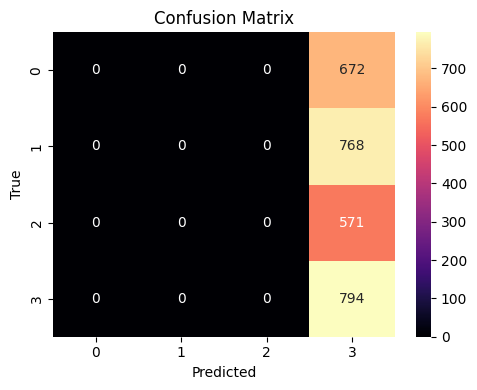

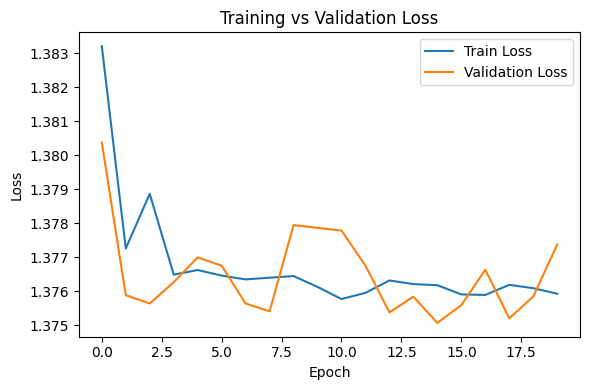

In [6]:
# --- LOAD BEST MODEL ---
model.load_state_dict(torch.load(os.path.join(RESULT_LOCAL, "model_best.pth")))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec  = recall_score(y_true, y_pred, average="macro")
f1   = f1_score(y_true, y_pred, average="macro")

metrics = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
with open(os.path.join(RESULT_LOCAL, "metrics_test.json"), "w") as f:
    json.dump(metrics, f, indent=4)

print("\n Test Results:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(RESULT_LOCAL, "confusion_matrix.png"))
plt.show()

# --- LOSS CURVE ---
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULT_LOCAL, "loss_curve.png"))
plt.show()

In [7]:
import shutil
print("Menyalin hasil ke Google Drive...")

if os.path.exists(RESULT_DRIVE):
    shutil.rmtree(RESULT_DRIVE)
shutil.copytree(RESULT_LOCAL, RESULT_DRIVE)

print(f"Hasil skenario {scenario_id} berhasil disalin ke Drive:")
print(RESULT_DRIVE)

Menyalin hasil ke Google Drive...
Hasil skenario 1a-2b-3a berhasil disalin ke Drive:
/content/drive/MyDrive/gerdpolyp-thesisv2/results/1a-2b-3a
